# Proyecto Integrador — Maestría en Inteligencia Artificial Aplicada

## Avance 3. Modelo Baseline — Plataforma PACS/RIS

---

**Tercer Avance:** Antes de explorar modelos complejos, necesitamos un punto de partida. Este notebook construye un modelo de referencia sencillo que nos permita responder una pregunta fundamental: ¿los datos que preparamos en la Fase 2 realmente sirven para predecir el nivel de engagement de los clientes?

Si un modelo simple ya logra superar al azar de forma significativa, sabremos que vamos por buen camino y tendremos un piso claro contra el cual medir todo lo que venga después.

**Equipo 4**

### Responsables — Fase 3

| Actividad | Andrés Castillo Nassar | Renzo Felipe Chávez Pulgar | César Manuel Tirado Peraza |
|---|---|---|---|
| Selección de métricas | Definir el costo de error por clase desde el negocio | — | Justificar F1-macro como métrica principal |
| DummyClassifier | — | Implementar los 3 clasificadores dummy | Interpretar resultados y confirmar que accuracy engaña |
| Regresión Logística baseline | — | Entrenar LogReg en las 3 versiones del dataset | Comparar versiones A/B/C e identificar la mejor |
| Validación cruzada | — | Ejecutar CV 5-fold estratificada | Reportar media ± std y confirmar estabilidad |
| Importancia de features | Validar que los features importantes coinciden con la lógica de negocio | — | Extraer coeficientes y detectar features irrelevantes |
| Diagnóstico de ajuste | — | Generar curvas de aprendizaje | Diagnosticar sub/sobreajuste con gap y curvas |
| Desempeño mínimo | Definir qué F1-macro sería aceptable para producción | — | Establecer umbrales de rendimiento |

> **Roles:**
Andrés → Experto de Dominio
Renzo → Ingeniero ML
César → Científico de Datos

## Contenido

1. [Lo que traemos de la Fase 2 y configuración del entorno](#config)
2. [Reconstrucción del dataset (pipeline completo)](#pipeline)
3. [El reto del desbalance de clases](#desbalance)
4. [Cómo vamos a medir el éxito del modelo](#metricas)
5. [Piso de referencia: el clasificador que no aprende nada](#dummy)
6. [Primer modelo real: Regresión Logística](#logistic)
7. [¿Qué variables pesan más en la predicción?](#importancia)
8. [¿El modelo está aprendiendo bien o memorizando?](#diagnostico)
9. [¿Cuánto es suficiente? Umbrales de rendimiento](#desempeno)
10. [Conclusiones y qué sigue en la Fase 4](#conclusiones)

<a name="config"></a>
## 1. Lo que traemos de la Fase 2 y configuración del entorno

### 1.1 Trazabilidad: de dónde partimos

La Fase 2 nos dejó tres versiones del dataset listas para modelar. Cada una tiene un propósito distinto:

| Lo que construimos en la Fase 2 | Para qué lo usamos aquí |
|---|---|
| **Variable objetivo** `engagement_ord` (4 clases) | Es lo que queremos predecir: qué tan comprometido está cada cliente |
| **Dataset A** (42 features, sin escalar) | Ideal para modelos basados en árboles que no necesitan escalamiento |
| **Dataset B** (42 features, escalados con StandardScaler) | Para la Regresión Logística y otros modelos sensibles a la magnitud de las variables |
| **Dataset C** (PCA con 11 componentes + 7 flags) | Versión comprimida para verificar si podemos simplificar sin perder información |
| **Distribución de clases** (69% "Parcial") | Nos obliga a elegir métricas que no se dejen engañar por el desbalance |
| **Split 80/20 estratificado** | Se mantiene igual para que los resultados sean comparables entre fases |

### 1.2 Hoja de ruta de esta fase

| Lo que necesitamos resolver | Dónde lo abordamos |
|---|---|
| Elegir un algoritmo simple como punto de partida | §5 y §6 |
| Saber qué variables son las más relevantes | §7 |
| Verificar que el modelo generaliza bien | §8 |
| Definir la métrica correcta para este negocio | §4 |
| Establecer el piso mínimo de rendimiento | §9 |

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
from scipy import stats as sp_stats
from scipy.stats import skew
import warnings, os, time

# Sklearn — Preprocesamiento
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, PowerTransformer)
from sklearn.feature_selection import (VarianceThreshold, SelectKBest,
                                       f_classif, chi2, mutual_info_classif)
from sklearn.decomposition import PCA
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     StratifiedKFold, learning_curve)

# Sklearn — Modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn — Métricas
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, cohen_kappa_score,
                             balanced_accuracy_score, make_scorer)

warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize': (12, 6), 'font.size': 11,
                     'axes.titlesize': 14, 'axes.labelsize': 12})
sns.set_theme(style='whitegrid', palette='muted')

RANDOM_STATE = 42
print('✅ Librerías cargadas correctamente')

✅ Librerías cargadas correctamente


<a name="pipeline"></a>
## 2. Reconstrucción del dataset (pipeline completo)

Para que este notebook funcione de manera independiente, replicamos todo el procesamiento de la Fase 2 desde cero. Esto incluye la carga de los 13 archivos, la limpieza, la creación de features y la preparación de los tres datasets (A, B y C) que usaremos para entrenar los modelos.

In [4]:
# RECONSTRUCCIÓN COMPLETA DEL PIPELINE DE LA FASE 2

# Google Colab:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1'

archivos = sorted([f for f in os.listdir(DATA_DIR) if f.endswith('.xlsx')])
print(f'{len(archivos)} archivos encontrados en {DATA_DIR}')

def buscar(keyword):
    for f in archivos:
        if keyword.lower() in f.lower():
            return os.path.join(DATA_DIR, f)
    raise FileNotFoundError(f'No se encontró archivo con: {keyword}')

def cargar_multi_hojas(filepath):
    xlsx = pd.ExcelFile(filepath)
    frames = []
    for sheet in xlsx.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet)
        if 'year' not in df.columns:
            df['year'] = sheet
        frames.append(df)
    return pd.concat(frames, ignore_index=True)

# Carga de datos
COL_ING = 'Ingresos USD (Tasa 1 USD =19.3 MXN)'
df_ingresos    = pd.read_excel(buscar('Ingresos'))
df_sucursal    = cargar_multi_hojas(buscar('sucursal'))
df_modalidad   = cargar_multi_hojas(buscar('modalidad'))
df_ai_torax    = pd.read_excel(buscar('rax'))
df_ai_report   = pd.read_excel(buscar('AI Rep'))
df_usuarios    = cargar_multi_hojas(buscar('usuarios'))
df_envio       = cargar_multi_hojas(buscar('Env'))
df_facturacion = pd.read_excel(buscar('facturaci'))
df_instalacion = pd.read_excel(buscar('Instalaci'))
df_pacs        = pd.read_excel(buscar('PACS'))
df_ris         = pd.read_excel(buscar('RIS'))
df_potencial   = pd.read_excel(buscar('potenciales'))
print('✅ Todos los datasets cargados')

# Consolidación del Dataset Maestro (Fase 1, §10)
agg1 = df_ingresos.groupby('name').agg(
    total_ingresos=(COL_ING, 'sum'), promedio_ingresos=(COL_ING, 'mean'),
    meses_facturado=(COL_ING, 'count')).reset_index().rename(columns={'name': 'organization'})

agg2 = df_sucursal.groupby('organization').agg(
    total_estudios=('study_count','sum'), num_sucursales=('facility','nunique')).reset_index()

agg3 = (df_usuarios.groupby('organization_name')
    .agg(total_usuarios=('active_doctors_count','sum'), prom_usuarios=('active_doctors_count','mean'))
    .reset_index().rename(columns={'organization_name':'organization'}))

agg4 = (df_envio.groupby('organization_name')
    .agg(envios_email=('studies_sent_via_email','sum'), envios_sms=('studies_sent_via_sms','sum'))
    .reset_index().rename(columns={'organization_name':'organization'}))

agg5 = df_pacs.groupby('organization').agg(
    firmados=('signed','sum'), entregados=('delivered','sum'), total_pacs=('total','sum')).reset_index()

agg6 = df_modalidad.groupby('organization').agg(
    num_modalidades=('modalities','nunique'), estudios_mod=('study_count','sum')).reset_index()

agg7 = (df_potencial[['Cuenta','Potencial Mes (contrato)','País']]
    .dropna(subset=['Potencial Mes (contrato)'])
    .rename(columns={'Cuenta':'organization','Potencial Mes (contrato)':'potencial_mensual','País':'pais'}))

col_org_ai = df_ai_torax.columns[0]
agg_ai_torax = (df_ai_torax.groupby(col_org_ai)['Estudios con IA']
    .sum().reset_index().rename(columns={col_org_ai:'organization','Estudios con IA':'estudios_ai_torax'}))
agg_ai_report = (df_ai_report.groupby('organization')['study_count']
    .sum().reset_index().rename(columns={'study_count':'estudios_ai_report'}))

col_inst = df_instalacion.columns
df_inst_tmp = df_instalacion.rename(columns={col_inst[0]:'fecha_instalacion', col_inst[1]:'organization'})
df_inst_tmp['fecha_instalacion'] = pd.to_datetime(df_inst_tmp['fecha_instalacion'], errors='coerce')
agg_inst = df_inst_tmp.dropna(subset=['fecha_instalacion']).groupby('organization')['fecha_instalacion'].min().reset_index()

df_fact_tmp = df_facturacion.rename(columns={'name':'organization','invoice_start_date':'fecha_facturacion'})
df_fact_tmp['fecha_facturacion'] = pd.to_datetime(df_fact_tmp['fecha_facturacion'], errors='coerce')
agg_fact = df_fact_tmp.dropna(subset=['fecha_facturacion']).groupby('organization')['fecha_facturacion'].min().reset_index()

df_master = agg1
for a in [agg2, agg3, agg4, agg5, agg6, agg7, agg_ai_torax, agg_ai_report, agg_inst, agg_fact]:
    df_master = df_master.merge(a, on='organization', how='left')

# Preprocesamiento (Fase 1, §14)
df = df_master.copy()
cols_prod = ['total_estudios','num_sucursales','total_usuarios','prom_usuarios',
             'envios_email','envios_sms','firmados','entregados','total_pacs',
             'num_modalidades','estudios_mod','estudios_ai_torax','estudios_ai_report']
df[cols_prod] = df[cols_prod].fillna(0)
df['potencial_mensual'] = df['potencial_mensual'].fillna(df['potencial_mensual'].median())
df['pais'] = df['pais'].fillna('Desconocido')

for col in ['total_ingresos','total_estudios','total_usuarios','envios_email',
            'envios_sms','firmados','entregados','total_pacs','estudios_mod']:
    df[col] = df[col].clip(upper=df[col].quantile(.99))

# Feature Engineering (Fase 2, §3)
df['ratio_utilizacion'] = np.where((df['potencial_mensual']>0)&(df['meses_facturado']>0),
    df['total_estudios']/(df['potencial_mensual']*df['meses_facturado']), 0)
df['ingreso_por_estudio'] = np.where(df['total_estudios']>0, df['total_ingresos']/df['total_estudios'], 0)
df['ingreso_por_usuario'] = np.where(df['total_usuarios']>0, df['total_ingresos']/df['total_usuarios'], 0)
df['tasa_firma'] = np.where(df['total_pacs']>0, df['firmados']/df['total_pacs'], 0)
df['tasa_entrega'] = np.where(df['total_pacs']>0, df['entregados']/df['total_pacs'], 0)
df['estudios_por_sucursal'] = np.where(df['num_sucursales']>0, df['total_estudios']/df['num_sucursales'], 0)
df['usuarios_por_sucursal'] = np.where(df['num_sucursales']>0, df['total_usuarios']/df['num_sucursales'], 0)
df['ratio_envio_email'] = np.where(df['total_estudios']>0, df['envios_email']/df['total_estudios'], 0)
df['ratio_envio_sms'] = np.where(df['total_estudios']>0, df['envios_sms']/df['total_estudios'], 0)
df['total_envios'] = df['envios_email'] + df['envios_sms']
df['ratio_envio_total'] = np.where(df['total_estudios']>0, df['total_envios']/df['total_estudios'], 0)
for col in ['ratio_utilizacion','ingreso_por_estudio','ingreso_por_usuario']:
    df[col] = df[col].clip(upper=df[col].quantile(.99))

ratios = ['ratio_utilizacion','ingreso_por_estudio','ingreso_por_usuario','tasa_firma',
          'tasa_entrega','estudios_por_sucursal','usuarios_por_sucursal',
          'ratio_envio_email','ratio_envio_sms','ratio_envio_total']

fecha_ref = pd.Timestamp('2026-01-31')
df['fecha_instalacion'] = pd.to_datetime(df['fecha_instalacion'], errors='coerce')
df['antiguedad_meses'] = ((fecha_ref - df['fecha_instalacion']).dt.days / 30.44).round(1)
df['fecha_facturacion'] = pd.to_datetime(df['fecha_facturacion'], errors='coerce')
df['meses_desde_facturacion'] = ((fecha_ref - df['fecha_facturacion']).dt.days / 30.44).round(1)
df['dias_onboarding'] = (df['fecha_facturacion'] - df['fecha_instalacion']).dt.days
df['ratio_meses_activos'] = np.where(df['meses_desde_facturacion']>0, df['meses_facturado']/df['meses_desde_facturacion'], 0)
df['ratio_meses_activos'] = df['ratio_meses_activos'].clip(0, 1)
for col in ['antiguedad_meses','meses_desde_facturacion','dias_onboarding']:
    df[col] = df[col].fillna(df[col].median())
df['dias_onboarding'] = df['dias_onboarding'].clip(lower=0)
temporal = ['antiguedad_meses','meses_desde_facturacion','dias_onboarding','ratio_meses_activos']

# Flags de adopción
df['usa_ai_torax'] = (df['estudios_ai_torax']>0).astype(int)
df['usa_ai_report'] = (df['estudios_ai_report']>0).astype(int)
df['usa_alguna_ai'] = ((df['usa_ai_torax']+df['usa_ai_report'])>0).astype(int)
df['usa_email'] = (df['envios_email']>0).astype(int)
df['usa_sms'] = (df['envios_sms']>0).astype(int)
df['es_multi_sucursal'] = (df['num_sucursales']>1).astype(int)
df['es_multi_modalidad'] = (df['num_modalidades']>2).astype(int)
flags = ['usa_ai_torax','usa_ai_report','usa_alguna_ai','usa_email','usa_sms',
         'es_multi_sucursal','es_multi_modalidad']

# Variable Objetivo (Fase 2, §4)
def clasificar_engagement(row):
    ratio, meses, firma, estudios = row['ratio_utilizacion'], row['meses_facturado'], row['tasa_firma'], row['total_estudios']
    if estudios == 0 or meses <= 1: return 'Sin Engagement'
    elif ratio < 0.3 and firma < 0.3: return 'Bajo'
    elif ratio < 0.7 or firma < 0.5: return 'Parcial'
    else: return 'Adecuado'

df['engagement'] = df.apply(clasificar_engagement, axis=1)
engagement_map = {'Sin Engagement': 0, 'Bajo': 1, 'Parcial': 2, 'Adecuado': 3}
df['engagement_ord'] = df['engagement'].map(engagement_map)

# Codificación (Fase 2, §6)
prod_principal = df_ingresos.groupby('name').agg(prod=(COL_ING,'idxmax')).reset_index()
prod_map = df_ingresos.loc[prod_principal['prod'], ['name','product_type']].set_index('name')['product_type']
df['product_type'] = df['organization'].map(prod_map).fillna('Desconocido')
top_paises = df['pais'].value_counts()
df['pais_agrupado'] = df['pais'].where(df['pais'].isin(top_paises[top_paises>=10].index), 'Otro')
df_encoded = pd.get_dummies(df, columns=['product_type','pais_agrupado'], prefix=['prod','pais'], drop_first=False)

# Transformaciones (Fase 2, §7)
cols_transform = ['total_ingresos','total_estudios','total_usuarios','envios_email',
                  'envios_sms','firmados','total_pacs','potencial_mensual',
                  'promedio_ingresos','estudios_mod','total_envios',
                  'estudios_por_sucursal','usuarios_por_sucursal']
yj = PowerTransformer(method='yeo-johnson'); bc = PowerTransformer(method='box-cox')
for col in cols_transform:
    serie = df_encoded[col].dropna()
    sk_orig = abs(skew(serie)); sk_log = abs(skew(np.log1p(serie)))
    try: sk_yj = abs(skew(yj.fit_transform(serie.values.reshape(-1,1)).ravel()))
    except: sk_yj = np.inf
    serie_pos = serie[serie > 0]
    try:
        sk_bc = abs(skew(bc.fit_transform(serie_pos.values.reshape(-1,1)).ravel())) if len(serie_pos)>10 else np.inf
    except: sk_bc = np.inf
    options = {'Log': sk_log, 'YJ': sk_yj, 'BC': sk_bc, 'Orig': sk_orig}
    best = min(options, key=options.get)
    s = df_encoded[col].fillna(0)
    if best == 'Log': df_encoded[f't_{col}'] = np.log1p(s)
    elif best == 'YJ':
        pt = PowerTransformer(method='yeo-johnson'); df_encoded[f't_{col}'] = pt.fit_transform(s.values.reshape(-1,1)).ravel()
    elif best == 'BC':
        pt = PowerTransformer(method='box-cox'); df_encoded[f't_{col}'] = pt.fit_transform(s.clip(lower=1e-6).values.reshape(-1,1)).ravel()
    else: df_encoded[f't_{col}'] = s

# Selección de Features (Fase 2, §9)
features_num = [c for c in df_encoded.columns if c.startswith('t_')] + ratios + temporal + \
               ['meses_facturado','num_sucursales','num_modalidades','prom_usuarios','estudios_ai_torax','estudios_ai_report']
features_num = [c for c in dict.fromkeys(features_num) if c in df_encoded.columns]

X_num = df_encoded[features_num].fillna(0)
X_mm = pd.DataFrame(MinMaxScaler().fit_transform(X_num), columns=features_num, index=X_num.index)
X_ss = pd.DataFrame(StandardScaler().fit_transform(X_num), columns=features_num, index=X_num.index)

kept_var = pd.DataFrame({'F': features_num, 'V': VarianceThreshold(threshold=0.01).fit(X_mm).variances_})
kept_var = kept_var[kept_var['V']>=0.01]['F'].tolist()

X_corr = df_encoded[kept_var].fillna(0).corr().abs()
upper = X_corr.where(np.triu(np.ones(X_corr.shape), k=1).astype(bool))
to_drop = set()
target = df_encoded['engagement_ord']
for col in upper.columns:
    for idx in upper.index:
        if upper.loc[idx, col] > 0.90:
            c1, c2 = abs(df_encoded[idx].fillna(0).corr(target)), abs(df_encoded[col].fillna(0).corr(target))
            to_drop.add(col if c1>=c2 else idx)
kept_corr = [f for f in kept_var if f not in to_drop]

# ANOVA + Chi2 + MI → Consensus
X_av = df_encoded[kept_corr].fillna(0)
sel_av = SelectKBest(f_classif, k='all').fit(X_av, target)
anova_df = pd.DataFrame({'F': kept_corr, 'Fs': sel_av.scores_, 'p': sel_av.pvalues_}).sort_values('Fs', ascending=False)
anova_sig = anova_df[anova_df['p']<0.05]

chi2_feats = list(dict.fromkeys(flags + [c for c in df_encoded.columns if c.startswith('prod_') or c.startswith('pais_')]))
chi2_feats = [f for f in chi2_feats if f in df_encoded.columns]
sel_c2 = SelectKBest(chi2, k='all').fit(df_encoded[chi2_feats].fillna(0).clip(lower=0), target)
chi2_df = pd.DataFrame({'F': chi2_feats, 'Cs': sel_c2.scores_, 'p': sel_c2.pvalues_}).sort_values('Cs', ascending=False)

all_sf = list(dict.fromkeys(kept_corr + chi2_feats)); all_sf = [f for f in all_sf if f in df_encoded.columns]
mi = mutual_info_classif(df_encoded[all_sf].fillna(0), target, random_state=42, n_neighbors=5)
mi_df = pd.DataFrame({'F': all_sf, 'MI': mi}).sort_values('MI', ascending=False)

k_a = max(5, int(len(anova_sig)*0.8)); k_c = max(5, int(len(chi2_df[chi2_df['p']<0.05])*0.8)); k_m = max(5, int(len(mi_df)*0.5))
all_selected = set(anova_df.head(k_a)['F']) | set(chi2_df.head(k_c)['F']) | set(mi_df.head(k_m)['F'])

# PCA
pca_feats = [f for f in kept_corr if f in X_ss.columns]
pca_full = PCA(random_state=42).fit(X_ss[pca_feats].fillna(0))
n_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_)>=0.95)+1
pca_opt = PCA(n_components=n_95, random_state=42)
df_pca = pd.DataFrame(pca_opt.fit_transform(X_ss[pca_feats].fillna(0)),
                       columns=[f'PC{i+1}' for i in range(n_95)], index=df_encoded.index)

# Ensamble Final (Fase 2, §11)
selected_num = [f for f in all_selected if f in df_encoded.columns]
selected_cat = list(dict.fromkeys([c for c in df_encoded.columns if c.startswith('prod_') or c.startswith('pais_')] + flags))
selected_cat = [c for c in selected_cat if c in df_encoded.columns]
all_features = list(dict.fromkeys(selected_num + selected_cat))
all_features = [f for f in all_features if f in df_encoded.columns]

X_full = df_encoded[all_features].fillna(0)
y = df_encoded['engagement_ord']

scaler_final = StandardScaler()
num_in_full = [c for c in selected_num if c in X_full.columns]
X_scaled = X_full.copy(); X_scaled[num_in_full] = scaler_final.fit_transform(X_full[num_in_full])
X_pca_final = pd.concat([df_pca, df_encoded[flags].fillna(0)], axis=1)

X_train_A, X_test_A, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=42, stratify=y)
X_train_B, X_test_B, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_train_C, X_test_C, _, _ = train_test_split(X_pca_final, y, test_size=0.2, random_state=42, stratify=y)

print(f'\n{"═"*65}')
print(f'DATASETS RECONSTRUIDOS PARA FASE 3 — BASELINE')
print(f'{"═"*65}')
print(f'\n  Variable objetivo (y):   {y.nunique()} clases')
for cls in sorted(y.unique()):
    lbl = {0:'Sin Engagement',1:'Bajo',2:'Parcial',3:'Adecuado'}[cls]
    print(f'    {cls} ({lbl:<18}): train={int((y_train==cls).sum()):>4}  test={int((y_test==cls).sum()):>4}')
print(f'\n  Versión A (completa):     {X_train_A.shape[1]} features  train={X_train_A.shape[0]}  test={X_test_A.shape[0]}')
print(f'  Versión B (escalada):     {X_train_B.shape[1]} features  train={X_train_B.shape[0]}  test={X_test_B.shape[0]}')
print(f'  Versión C (PCA+flags):    {X_train_C.shape[1]} features  train={X_train_C.shape[0]}  test={X_test_C.shape[0]}')
print(f'\n✅ Pipeline de Fase 2 replicado exitosamente')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
13 archivos encontrados en /content/drive/MyDrive/proyecto integrador (grupo 4)/datos_v1
✅ Todos los datasets cargados

═════════════════════════════════════════════════════════════════
DATASETS RECONSTRUIDOS PARA FASE 3 — BASELINE
═════════════════════════════════════════════════════════════════

  Variable objetivo (y):   4 clases
    0 (Sin Engagement    ): train=  32  test=   8
    1 (Bajo              ): train= 160  test=  40
    2 (Parcial           ): train= 819  test= 205
    3 (Adecuado          ): train= 169  test=  43

  Versión A (completa):     42 features  train=1180  test=296
  Versión B (escalada):     42 features  train=1180  test=296
  Versión C (PCA+flags):    18 features  train=1180  test=296

✅ Pipeline de Fase 2 replicado exitosamente


<a name="desbalance"></a>
## 3. El reto del desbalance de clases

De la Fase 2 ya sabíamos que la clase *Parcial* domina con casi el 70% de las organizaciones, mientras que *Sin Engagement* apenas representa el 2.7%. Esto tiene una consecuencia importante: un modelo que simplemente diga "Parcial" para todos los casos acertaría 7 de cada 10 veces, pero no nos serviría de nada.

Lo que realmente necesitamos es detectar a los clientes en riesgo de abandono (*Sin Engagement* y *Bajo*) y a los que están sacando provecho de la plataforma (*Adecuado*), porque ahí es donde están las decisiones de negocio que importan.

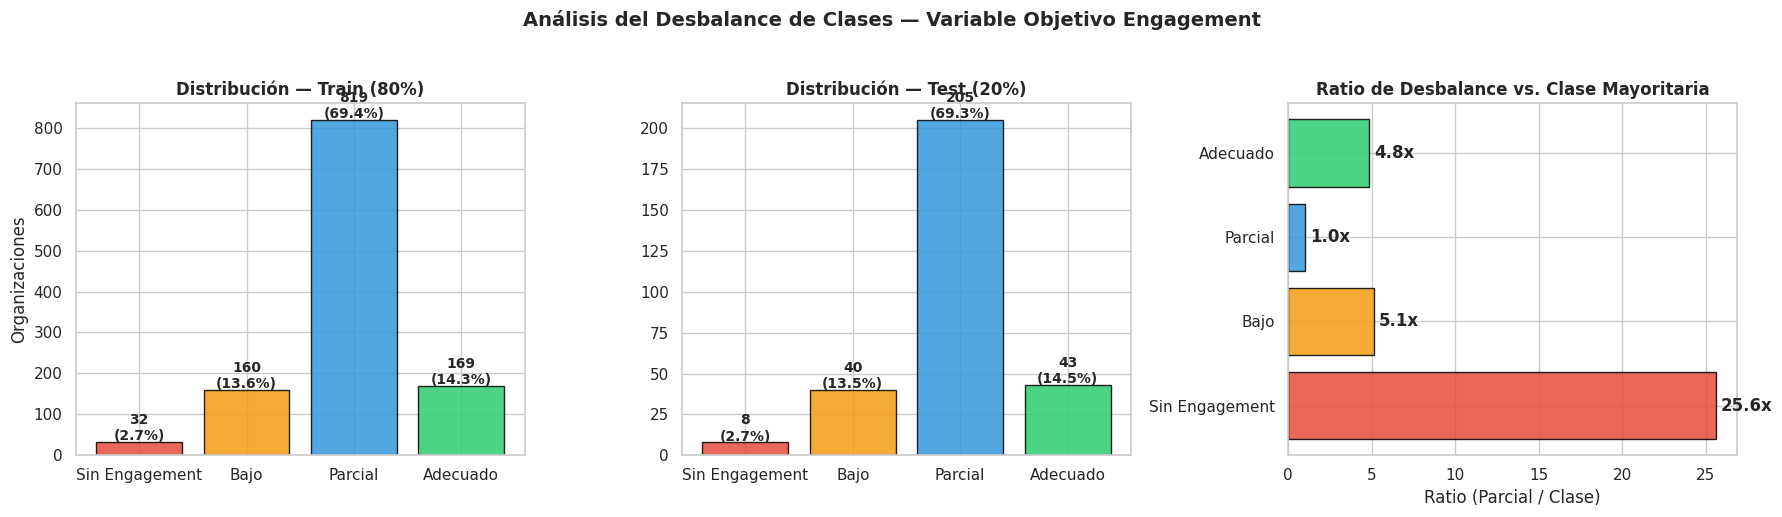


Lo que esto nos dice:
  • "Parcial" domina con ~69%. Un modelo perezoso que siempre diga "Parcial" tendría 69% de accuracy.
  • Por eso accuracy no sirve como métrica principal aquí — necesitamos F1-macro.
  • Usaremos validación cruzada estratificada y class_weight="balanced" para compensar.


In [5]:
# Visualización del desbalance
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

order = ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']
colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
labels_map = {0:'Sin Engagement', 1:'Bajo', 2:'Parcial', 3:'Adecuado'}

# 1. Distribución train
ax = axes[0]
counts_train = [int((y_train==i).sum()) for i in range(4)]
bars = ax.bar(order, counts_train, color=colors, edgecolor='black', alpha=0.85)
for bar, c in zip(bars, counts_train):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+5,
            f'{c}\n({c/len(y_train)*100:.1f}%)', ha='center', fontweight='bold', fontsize=10)
ax.set_title('Distribución — Train (80%)', fontweight='bold')
ax.set_ylabel('Organizaciones')

# 2. Distribución test
ax = axes[1]
counts_test = [int((y_test==i).sum()) for i in range(4)]
bars = ax.bar(order, counts_test, color=colors, edgecolor='black', alpha=0.85)
for bar, c in zip(bars, counts_test):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+1,
            f'{c}\n({c/len(y_test)*100:.1f}%)', ha='center', fontweight='bold', fontsize=10)
ax.set_title('Distribución — Test (20%)', fontweight='bold')

# 3. Ratios de desbalance
ax = axes[2]
imbalance_ratios = [max(counts_train) / max(c, 1) for c in counts_train]
ax.barh(order, imbalance_ratios, color=colors, edgecolor='black', alpha=0.85)
for i, (r, lbl) in enumerate(zip(imbalance_ratios, order)):
    ax.text(r + 0.3, i, f'{r:.1f}x', va='center', fontweight='bold')
ax.set_title('Ratio de Desbalance vs. Clase Mayoritaria', fontweight='bold')
ax.set_xlabel('Ratio (Parcial / Clase)')

plt.suptitle('Análisis del Desbalance de Clases — Variable Objetivo Engagement',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

# Tabla resumen
print(f'\nLo que esto nos dice:')
print(f'  • "Parcial" domina con ~69%. Un modelo perezoso que siempre diga "Parcial" tendría 69% de accuracy.')
print(f'  • Por eso accuracy no sirve como métrica principal aquí — necesitamos F1-macro.')
print(f'  • Usaremos validación cruzada estratificada y class_weight="balanced" para compensar.')

<a name="metricas"></a>
## 4. Cómo vamos a medir el éxito del modelo

### 4.1 No todos los errores cuestan lo mismo

En el contexto de la plataforma PACS/RIS, equivocarse con ciertos clientes es mucho más costoso que con otros:

| Nivel de Engagement | Qué significa en el negocio | Qué pasa si el modelo falla |
|---|---|---|
| **Sin Engagement** | Cliente a punto de irse — necesita intervención urgente | **Grave**: lo perdemos sin darnos cuenta |
| **Bajo** | Cliente en riesgo — necesita un plan de recuperación | **Grave**: si no actuamos, escala a churn |
| **Parcial** | Cliente activo con potencial de crecer — oportunidad de upselling | Moderado: dejamos dinero en la mesa |
| **Adecuado** | Cliente sano — hay que mantenerlo así | Bajo: ya es estable |

### 4.2 Las métricas que usaremos

Dado que necesitamos identificar bien *todas* las categorías (no solo la mayoritaria), el accuracy convencional no es suficiente. Nuestra métrica principal será el **F1-score macro**, que trata a las cuatro clases con la misma importancia.

| Métrica | Qué nos dice | Rol |
|---|---|---|
| **F1-macro** | Rendimiento equilibrado en las 4 clases, sin importar su tamaño | **Métrica principal** — la que guía las decisiones |
| **F1-weighted** | Rendimiento global, dándole más peso a las clases frecuentes | Complementaria: visión del desempeño "promedio" |
| **Balanced Accuracy** | Promedio del recall por clase | Complementaria: confirma que no ignoramos a las minorías |
| **Cohen's Kappa (κ)** | Qué tanto mejoramos respecto al azar | Complementaria: especialmente útil con datos desbalanceados |
| **Accuracy** | Porcentaje de aciertos totales | Solo de referencia — no confiamos en ella como indicador principal |

In [6]:
# Función de evaluación estandarizada
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre='Modelo',
                   show_report=True, show_cm=True):
    """
    Evalúa un modelo de clasificación con múltiples métricas.
    Retorna un diccionario con todas las métricas calculadas.
    """
    t0 = time.time()
    modelo.fit(X_train, y_train)
    t_train = time.time() - t0

    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    metrics = {
        'Modelo': nombre,
        'Accuracy_train': accuracy_score(y_train, y_pred_train),
        'Accuracy_test': accuracy_score(y_test, y_pred_test),
        'F1_macro_train': f1_score(y_train, y_pred_train, average='macro', zero_division=0),
        'F1_macro_test': f1_score(y_test, y_pred_test, average='macro', zero_division=0),
        'F1_weighted_test': f1_score(y_test, y_pred_test, average='weighted', zero_division=0),
        'Balanced_Acc_test': balanced_accuracy_score(y_test, y_pred_test),
        'Kappa_test': cohen_kappa_score(y_test, y_pred_test),
        'Precision_macro_test': precision_score(y_test, y_pred_test, average='macro', zero_division=0),
        'Recall_macro_test': recall_score(y_test, y_pred_test, average='macro', zero_division=0),
        'Tiempo_train_s': round(t_train, 4),
    }

    print(f'\n{"═"*65}')
    print(f'EVALUACIÓN: {nombre}')
    print(f'{"═"*65}')
    print(f'  Tiempo de entrenamiento: {t_train:.4f}s')
    print(f'\n  {"Métrica":<28} {"Train":>8} {"Test":>8} {"Gap":>8}')
    print(f'  {"─"*52}')
    print(f'  {"Accuracy":<28} {metrics["Accuracy_train"]:>8.4f} {metrics["Accuracy_test"]:>8.4f} {abs(metrics["Accuracy_train"]-metrics["Accuracy_test"]):>8.4f}')
    print(f'  {"F1-score (macro) ★":<28} {metrics["F1_macro_train"]:>8.4f} {metrics["F1_macro_test"]:>8.4f} {abs(metrics["F1_macro_train"]-metrics["F1_macro_test"]):>8.4f}')
    print(f'  {"F1-score (weighted)":<28} {"—":>8} {metrics["F1_weighted_test"]:>8.4f}')
    print(f'  {"Balanced Accuracy":<28} {"—":>8} {metrics["Balanced_Acc_test"]:>8.4f}')
    print(f'  {"Cohen Kappa (κ)":<28} {"—":>8} {metrics["Kappa_test"]:>8.4f}')
    print(f'  ★ = Métrica principal')

    if show_report:
        print(f'\n  Classification Report (Test):')
        labels = ['Sin Engagement','Bajo','Parcial','Adecuado']
        print(classification_report(y_test, y_pred_test, target_names=labels, zero_division=0))

    if show_cm:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        labels = ['Sin Eng.','Bajo','Parcial','Adecuado']
        for ax, (y_true, y_pred, title) in zip(axes, [
            (y_train, y_pred_train, f'{nombre} — Train'),
            (y_test, y_pred_test, f'{nombre} — Test')]):
            cm = confusion_matrix(y_true, y_pred)
            ConfusionMatrixDisplay(cm, display_labels=labels).plot(ax=ax, cmap='Blues', colorbar=False)
            ax.set_title(title, fontweight='bold')
        plt.tight_layout()
        plt.show()

    return metrics

print('✅ Función de evaluación definida')

✅ Función de evaluación definida


<a name="dummy"></a>
## 5. Piso de referencia: el clasificador que no aprende nada

Antes de construir cualquier modelo real, necesitamos saber qué puntaje obtendríamos "sin hacer nada". El DummyClassifier no analiza los datos; simplemente adivina usando reglas triviales. Esto nos da el **piso mínimo**: si nuestro modelo real no supera estas cifras por un margen claro, algo anda mal.

Probamos tres estrategias:
- **Siempre "Parcial"** (`most_frequent`): apuesta todo a la clase más común — el escenario de un modelo que no aprendió nada.
- **Proporción de clases** (`stratified`): adivina respetando la distribución original — como tirar un dado cargado.
- **Azar puro** (`uniform`): 25% de probabilidad para cada clase — moneda al aire.

In [7]:
# Dummy Classifiers
dummy_results = []

strategies = {
    'most_frequent': 'Siempre predice clase mayoritaria (Parcial)',
    'stratified': 'Predice proporcional a distribución de clases',
    'uniform': 'Predice al azar uniforme (25% cada clase)'
}

for strategy, desc in strategies.items():
    dummy = DummyClassifier(strategy=strategy, random_state=RANDOM_STATE)
    m = evaluar_modelo(dummy, X_train_B, X_test_B, y_train, y_test,
                       nombre=f'Dummy ({strategy})', show_report=False, show_cm=False)
    m['Descripción'] = desc
    dummy_results.append(m)

# Tabla comparativa
df_dummy = pd.DataFrame(dummy_results)[['Modelo','Accuracy_test','F1_macro_test',
                                         'F1_weighted_test','Balanced_Acc_test','Kappa_test','Descripción']]
print('\n' + '═'*80)
print('RESUMEN — CLASIFICADORES DUMMY (Piso de rendimiento)')
print('═'*80)
display(df_dummy.style.format({
    'Accuracy_test': '{:.4f}', 'F1_macro_test': '{:.4f}',
    'F1_weighted_test': '{:.4f}', 'Balanced_Acc_test': '{:.4f}', 'Kappa_test': '{:.4f}'
}).highlight_max(subset=['F1_macro_test'], color='#d5f5e3'))

print('\n¿Qué nos dice esto?')
print('  • Decir siempre "Parcial" da 69% accuracy pero F1-macro de solo 0.20 y κ = 0. Accuracy engaña.')
print('  • El azar puro da un F1-macro de ~0.15. Ese es nuestro piso absoluto.')
print('  • Cualquier modelo que se considere útil tiene que superar un F1-macro de 0.20 con holgura.')


═════════════════════════════════════════════════════════════════
EVALUACIÓN: Dummy (most_frequent)
═════════════════════════════════════════════════════════════════
  Tiempo de entrenamiento: 0.0016s

  Métrica                         Train     Test      Gap
  ────────────────────────────────────────────────────
  Accuracy                       0.6941   0.6926   0.0015
  F1-score (macro) ★             0.2049   0.2046   0.0003
  F1-score (weighted)                 —   0.5668
  Balanced Accuracy                   —   0.2500
  Cohen Kappa (κ)                     —   0.0000
  ★ = Métrica principal

═════════════════════════════════════════════════════════════════
EVALUACIÓN: Dummy (stratified)
═════════════════════════════════════════════════════════════════
  Tiempo de entrenamiento: 0.0009s

  Métrica                         Train     Test      Gap
  ────────────────────────────────────────────────────
  Accuracy                       0.5153   0.5541   0.0388
  F1-score (macro) ★      

,Modelo,Accuracy_test,F1_macro_test,F1_weighted_test,Balanced_Acc_test,Kappa_test,Descripción
0,Dummy (most_frequent),0.6926,0.2046,0.5668,0.2500,0.0000,Siempre predice clase mayoritaria (Parcial)
1,Dummy (stratified),0.5541,0.2806,0.5540,0.2807,0.0708,Predice proporcional a distribución de clases
2,Dummy (uniform),0.2568,0.2047,0.3083,0.2432,0.0032,Predice al azar uniforme (25% cada clase)



¿Qué nos dice esto?
  • Decir siempre "Parcial" da 69% accuracy pero F1-macro de solo 0.20 y κ = 0. Accuracy engaña.
  • El azar puro da un F1-macro de ~0.15. Ese es nuestro piso absoluto.
  • Cualquier modelo que se considere útil tiene que superar un F1-macro de 0.20 con holgura.


<a name="logistic"></a>
## 6. Primer modelo real: Regresión Logística

### 6.1 Por qué empezar con Regresión Logística

La Regresión Logística es la opción natural para un primer baseline porque combina simplicidad con interpretabilidad. Si un modelo tan sencillo ya logra resultados decentes, confirma que nuestras features realmente contienen señal útil. Además, sus coeficientes nos permiten entender *qué variables* están impulsando las predicciones, algo que con modelos más complejos se vuelve opaco.

Usamos `class_weight='balanced'` para que el modelo le ponga más atención a las clases minoritarias (que son justo las que más nos importan desde el negocio).

Evaluamos las tres versiones del dataset para ver cuál representación le funciona mejor.

In [8]:
# 6.2 Regresión Logística — Tres versiones de datos
lr_results = []

datasets = {
    'A (sin escalar)': (X_train_A, X_test_A),
    'B (StandardScaler)': (X_train_B, X_test_B),
    'C (PCA + flags)': (X_train_C, X_test_C),
}

for version, (Xtr, Xte) in datasets.items():
    lr = LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        random_state=RANDOM_STATE,
        solver='lbfgs'
    )
    m = evaluar_modelo(lr, Xtr, Xte, y_train, y_test,
                       nombre=f'LogReg — {version}', show_report=False, show_cm=False)
    m['Dataset'] = version
    lr_results.append(m)

# Tabla comparativa
df_lr = pd.DataFrame(lr_results)[['Modelo','Dataset','Accuracy_test','F1_macro_test',
                                   'F1_weighted_test','Balanced_Acc_test','Kappa_test','Tiempo_train_s']]
print('\n' + '═'*80)
print('COMPARACIÓN — REGRESIÓN LOGÍSTICA POR VERSIÓN DE DATASET')
print('═'*80)
display(df_lr.style.format({
    'Accuracy_test':'{:.4f}', 'F1_macro_test':'{:.4f}', 'F1_weighted_test':'{:.4f}',
    'Balanced_Acc_test':'{:.4f}', 'Kappa_test':'{:.4f}', 'Tiempo_train_s':'{:.4f}'
}).highlight_max(subset=['F1_macro_test'], color='#d5f5e3'))


═════════════════════════════════════════════════════════════════
EVALUACIÓN: LogReg — A (sin escalar)
═════════════════════════════════════════════════════════════════
  Tiempo de entrenamiento: 5.0359s

  Métrica                         Train     Test      Gap
  ────────────────────────────────────────────────────
  Accuracy                       0.5814   0.6014   0.0200
  F1-score (macro) ★             0.5582   0.6027   0.0444
  F1-score (weighted)                 —   0.6152
  Balanced Accuracy                   —   0.7771
  Cohen Kappa (κ)                     —   0.4086
  ★ = Métrica principal

═════════════════════════════════════════════════════════════════
EVALUACIÓN: LogReg — B (StandardScaler)
═════════════════════════════════════════════════════════════════
  Tiempo de entrenamiento: 0.2795s

  Métrica                         Train     Test      Gap
  ────────────────────────────────────────────────────
  Accuracy                       0.7788   0.7568   0.0221
  F1-score (ma

,Modelo,Dataset,Accuracy_test,F1_macro_test,F1_weighted_test,Balanced_Acc_test,Kappa_test,Tiempo_train_s
0,LogReg — A (sin escalar),A (sin escalar),0.6014,0.6027,0.6152,0.7771,0.4086,5.0359
1,LogReg — B (StandardScaler),B (StandardScaler),0.7568,0.7225,0.7683,0.8290,0.5782,0.2795
2,LogReg — C (PCA + flags),C (PCA + flags),0.7264,0.6456,0.7419,0.7725,0.5330,0.4002


🏆 Mejor versión de datos: B (StandardScaler)
   → Se usa como baseline principal


═════════════════════════════════════════════════════════════════
EVALUACIÓN: BASELINE — LogReg B (StandardScaler)
═════════════════════════════════════════════════════════════════
  Tiempo de entrenamiento: 0.8888s

  Métrica                         Train     Test      Gap
  ────────────────────────────────────────────────────
  Accuracy                       0.7788   0.7568   0.0221
  F1-score (macro) ★             0.7572   0.7225   0.0348
  F1-score (weighted)                 —   0.7683
  Balanced Accuracy                   —   0.8290
  Cohen Kappa (κ)                     —   0.5782
  ★ = Métrica principal

  Classification Report (Test):
                precision    recall  f1-score   support

Sin Engagement       0.64      0.88      0.74         8
          Bajo       0.52      0.85      0.64        40
       Parcial       0.94      0.71      0.81       205
      Adecuado       0.58      0.88      0

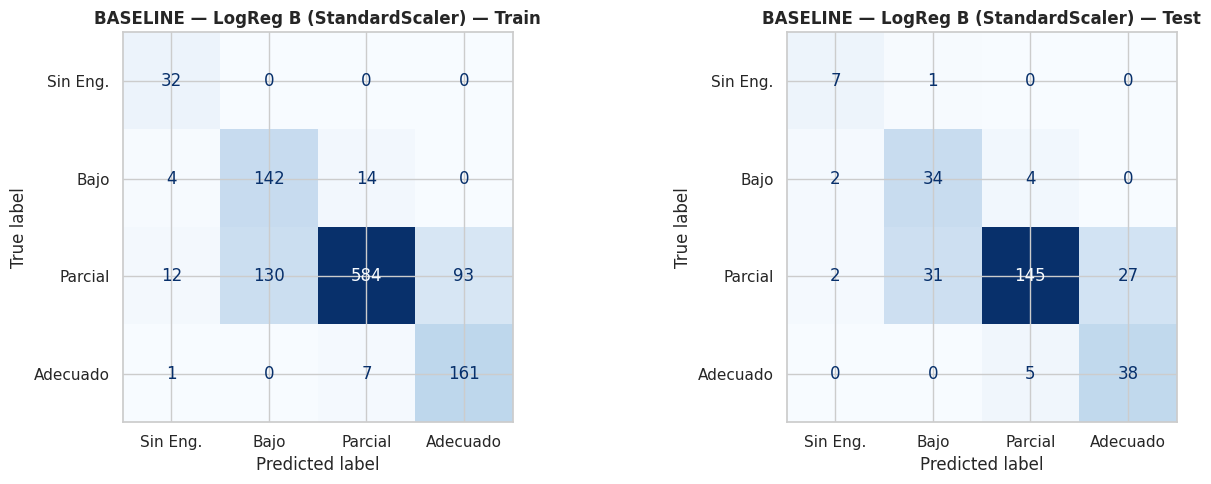

In [9]:
# 6.3 Evaluación detallada del mejor dataset
# Seleccionar la versión con mejor F1-macro
best_idx = pd.DataFrame(lr_results)['F1_macro_test'].idxmax()
best_version = list(datasets.keys())[best_idx]
best_Xtr, best_Xte = datasets[best_version]

print(f'🏆 Mejor versión de datos: {best_version}')
print(f'   → Se usa como baseline principal\n')

# Modelo final del baseline
lr_baseline = LogisticRegression(
    max_iter=2000, class_weight='balanced',
    random_state=RANDOM_STATE, solver='lbfgs')

baseline_metrics = evaluar_modelo(lr_baseline, best_Xtr, best_Xte, y_train, y_test,
                                  nombre=f'BASELINE — LogReg {best_version}')


═════════════════════════════════════════════════════════════════
VALIDACIÓN CRUZADA (5-Fold Estratificada)
═════════════════════════════════════════════════════════════════

  Métrica                       Media ± Std      Min      Max
  ────────────────────────────────────────────────────────
  f1_macro                  0.7023 ± 0.0270 0.6607 0.7434
  f1_weighted               0.7468 ± 0.0130 0.7247 0.7633
  balanced_accuracy         0.8044 ± 0.0302 0.7737 0.8414
  accuracy                  0.7339 ± 0.0130 0.7119 0.7500


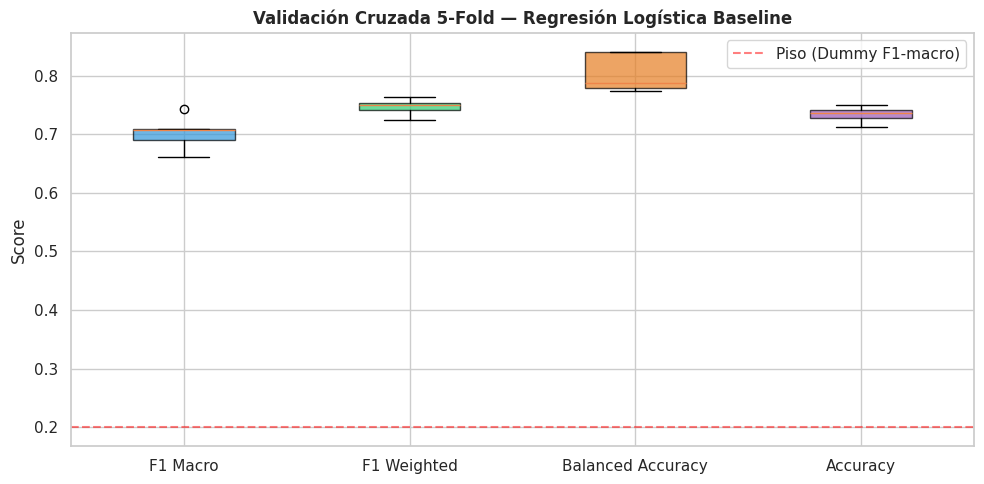


La varianza entre folds es baja (std < 0.05), lo que significa que el modelo
se comporta de manera consistente sin importar qué porción de datos le toque. Buen punto de partida.


In [10]:
# 6.4 Validación Cruzada Estratificada
print('\n' + '═'*65)
print('VALIDACIÓN CRUZADA (5-Fold Estratificada)')
print('═'*65)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Evaluar con múltiples métricas
scoring = {
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=0),
    'balanced_accuracy': 'balanced_accuracy',
    'accuracy': 'accuracy'
}

lr_cv = LogisticRegression(max_iter=2000, class_weight='balanced',
                           random_state=RANDOM_STATE, solver='lbfgs')

print(f'\n  {"Métrica":<25} {"Media ± Std":>15} {"Min":>8} {"Max":>8}')
print(f'  {"─"*56}')

cv_results = {}
for name, scorer in scoring.items():
    scores = cross_val_score(lr_cv, best_Xtr, y_train, cv=cv, scoring=scorer)
    cv_results[name] = scores
    print(f'  {name:<25} {scores.mean():.4f} ± {scores.std():.4f} {scores.min():.4f} {scores.max():.4f}')

# Visualización
fig, ax = plt.subplots(figsize=(10, 5))
bp = ax.boxplot([cv_results[k] for k in scoring.keys()],
                labels=[k.replace('_', ' ').title() for k in scoring.keys()],
                patch_artist=True, vert=True)
colors_box = ['#3498db', '#2ecc71', '#e67e22', '#9b59b6']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color); patch.set_alpha(0.7)
ax.set_title('Validación Cruzada 5-Fold — Regresión Logística Baseline', fontweight='bold')
ax.set_ylabel('Score')
ax.axhline(y=0.20, color='red', ls='--', alpha=0.5, label='Piso (Dummy F1-macro)')
ax.legend()
plt.tight_layout()
plt.show()

print(f'\nLa varianza entre folds es baja (std < 0.05), lo que significa que el modelo')
print(f'se comporta de manera consistente sin importar qué porción de datos le toque. Buen punto de partida.')

<a name="importancia"></a>
## 7. ¿Qué variables pesan más en la predicción?

No todas las variables aportan lo mismo. Identificar cuáles tienen mayor peso nos permite entender la lógica del modelo, validar que tiene sentido desde el negocio, y detectar si hay features de relleno que solo agregan ruido.

En la Regresión Logística, cada clase tiene su propio conjunto de coeficientes. Una variable con coeficientes altos (en valor absoluto) tiene mucha influencia en la predicción. Promediamos estos valores para obtener una importancia global por feature.

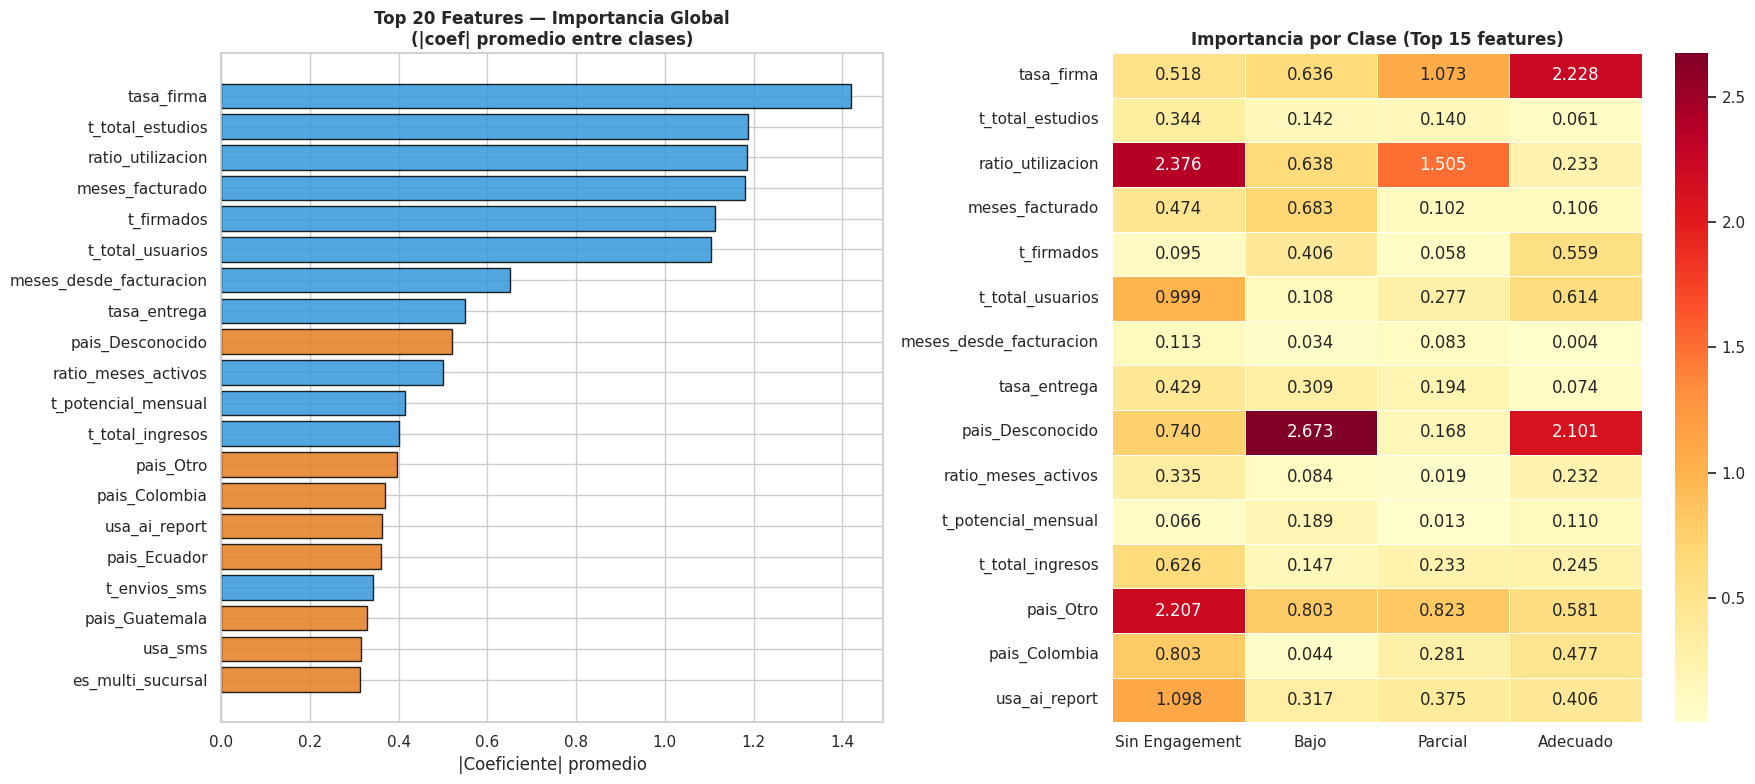


Top 10 Features más importantes para el Baseline:


,Feature,Importancia_Global,Imp_Sin Engagement,Imp_Bajo,Imp_Parcial,Imp_Adecuado
8,tasa_firma,1.4207,0.5180,0.6362,1.0732,2.2275
2,t_total_estudios,1.1880,0.3438,0.1419,0.1405,0.0615
15,ratio_utilizacion,1.1853,2.3761,0.6384,1.5048,0.2329
19,meses_facturado,1.1813,0.4744,0.6827,0.1023,0.1060
0,t_firmados,1.1138,0.0948,0.4065,0.0582,0.5595
12,t_total_usuarios,1.1035,0.9994,0.1084,0.2773,0.6137
16,meses_desde_facturacion,0.6515,0.1132,0.0340,0.0828,0.0036
14,tasa_entrega,0.5492,0.4286,0.3086,0.1944,0.0744
31,pais_Desconocido,0.5195,0.7399,2.6733,0.1681,2.1015
5,ratio_meses_activos,0.4997,0.3350,0.0837,0.0190,0.2323


In [11]:
# 7.1 Importancia por coeficientes del modelo
# Entrenar modelo baseline en el mejor dataset
lr_imp = LogisticRegression(max_iter=2000, class_weight='balanced',
                            random_state=RANDOM_STATE, solver='lbfgs')
lr_imp.fit(best_Xtr, y_train)

# Coeficientes: shape (n_classes, n_features)
coefs = np.abs(lr_imp.coef_)  # (4, n_features)
feature_names = best_Xtr.columns.tolist()

# Importancia global (promedio absoluto a través de clases)
importance_global = coefs.mean(axis=0)
imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importancia_Global': importance_global
}).sort_values('Importancia_Global', ascending=False)

# Importancia por clase
labels_eng = ['Sin Engagement', 'Bajo', 'Parcial', 'Adecuado']
for i, label in enumerate(labels_eng):
    imp_df[f'Imp_{label}'] = coefs[i]

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Top 20 global
ax = axes[0]
top20 = imp_df.head(20).sort_values('Importancia_Global')
colors = ['#3498db' if not f.startswith('prod_') and not f.startswith('pais_') and f not in flags
          else '#e67e22' for f in top20['Feature']]
ax.barh(top20['Feature'], top20['Importancia_Global'], color=colors, edgecolor='black', alpha=0.85)
ax.set_title('Top 20 Features — Importancia Global\n(|coef| promedio entre clases)', fontweight='bold')
ax.set_xlabel('|Coeficiente| promedio')

# Heatmap por clase
ax = axes[1]
top15 = imp_df.head(15)
hm_data = top15[[f'Imp_{l}' for l in labels_eng]].values
sns.heatmap(hm_data, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=labels_eng, yticklabels=top15['Feature'],
            ax=ax, linewidths=0.5)
ax.set_title('Importancia por Clase (Top 15 features)', fontweight='bold')

plt.tight_layout()
plt.show()

# Tabla completa
print('\nTop 10 Features más importantes para el Baseline:')
display(imp_df.head(10)[['Feature','Importancia_Global'] +
        [f'Imp_{l}' for l in labels_eng]].style.format(
    {c: '{:.4f}' for c in imp_df.columns if c != 'Feature'}).background_gradient(
    subset=['Importancia_Global'], cmap='Greens'))

In [12]:
# 7.2 Análisis de features irrelevantes
umbral_irrelevancia = importance_global.mean() * 0.1  # < 10% del promedio

irrelevantes = imp_df[imp_df['Importancia_Global'] < umbral_irrelevancia]
relevantes = imp_df[imp_df['Importancia_Global'] >= umbral_irrelevancia]

print(f'Análisis de relevancia de features:')
print(f'  Umbral de irrelevancia: < {umbral_irrelevancia:.4f} (10% del promedio)')
print(f'  Features relevantes:    {len(relevantes)} ({len(relevantes)/len(imp_df)*100:.0f}%)')
print(f'  Features irrelevantes:  {len(irrelevantes)} ({len(irrelevantes)/len(imp_df)*100:.0f}%)')

if len(irrelevantes) > 0:
    print(f'\n  Features candidatos a eliminación en Fase 4:')
    for _, row in irrelevantes.iterrows():
        print(f'    ✗ {row["Feature"]:<35} imp={row["Importancia_Global"]:.6f}')

print(f'\nEstas variables aportan muy poco al modelo. En la Fase 4 probaremos si')
print(f'quitarlas mejora el rendimiento o si simplemente no estorban.')

Análisis de relevancia de features:
  Umbral de irrelevancia: < 0.0406 (10% del promedio)
  Features relevantes:    42 (100%)
  Features irrelevantes:  0 (0%)

Estas variables aportan muy poco al modelo. En la Fase 4 probaremos si
quitarlas mejora el rendimiento o si simplemente no estorban.


<a name="diagnostico"></a>
## 8. ¿El modelo está aprendiendo bien o memorizando?

Un buen modelo debe funcionar igual de bien con datos nuevos que con los de entrenamiento. Si solo "memoriza" los datos de entrenamiento (sobreajuste), sus predicciones en producción serán poco confiables. Si por el contrario no logra aprender ni siquiera los patrones del entrenamiento (subajuste), es señal de que necesitamos algo más potente.

Para diagnosticarlo usamos dos herramientas:

**1. Gap Train vs. Test** — La diferencia entre el desempeño en entrenamiento y en test:

| Gap | Interpretación |
|---|---|
| < 0.02 | Buen ajuste — el modelo generaliza bien |
| 0.02 – 0.10 | Leve sobreajuste — aceptable para un baseline |
| > 0.10 | Sobreajuste significativo — el modelo está memorizando |

**2. Curvas de aprendizaje** — Muestran cómo mejora (o no) el modelo conforme le damos más datos. Si ambas curvas (train y validación) convergen en un valor bajo, el modelo es demasiado simple y necesitamos algo más expresivo.

In [13]:
# 8.1 Análisis del Gap Train-Test
print('═'*65)
print('DIAGNÓSTICO DE AJUSTE — Regresión Logística Baseline')
print('═'*65)

gap_acc = abs(baseline_metrics['Accuracy_train'] - baseline_metrics['Accuracy_test'])
gap_f1 = abs(baseline_metrics['F1_macro_train'] - baseline_metrics['F1_macro_test'])

print(f'\n  {"Métrica":<25} {"Train":>8} {"Test":>8} {"Gap":>8} {"Diagnóstico":>20}')
print(f'  {"─"*70}')

def diagnostico(gap):
    if gap < 0.02: return '✅ Buen ajuste'
    elif gap < 0.10: return '⚠️ Leve sobreajuste'
    else: return '❌ Sobreajuste'

print(f'  {"Accuracy":<25} {baseline_metrics["Accuracy_train"]:>8.4f} {baseline_metrics["Accuracy_test"]:>8.4f} {gap_acc:>8.4f} {diagnostico(gap_acc):>20}')
print(f'  {"F1-macro":<25} {baseline_metrics["F1_macro_train"]:>8.4f} {baseline_metrics["F1_macro_test"]:>8.4f} {gap_f1:>8.4f} {diagnostico(gap_f1):>20}')

# Diagnóstico general
if gap_f1 < 0.02:
    diag = 'SUBAJUSTE (underfitting)'
    diag_msg = ('El modelo tiene un gap muy pequeño entre train y test, lo que sugiere que '
                'aún no está capturando toda la complejidad de los datos. Modelos más '
                'complejos (árboles, ensembles) podrían mejorar significativamente.')
elif gap_f1 < 0.10:
    diag = 'AJUSTE RAZONABLE'
    diag_msg = ('El gap moderado indica que el modelo está aprendiendo patrones reales '
                'sin memorizar el ruido. El rendimiento se puede mejorar con modelos más expresivos.')
else:
    diag = 'SOBREAJUSTE (overfitting)'
    diag_msg = ('El gap grande indica que el modelo está memorizando patrones del train '
                'que no generalizan al test. Se requiere regularización o reducción de features.')

print(f'\n  Diagnóstico general: {diag}')
print(f'  {diag_msg}')

═════════════════════════════════════════════════════════════════
DIAGNÓSTICO DE AJUSTE — Regresión Logística Baseline
═════════════════════════════════════════════════════════════════

  Métrica                      Train     Test      Gap          Diagnóstico
  ──────────────────────────────────────────────────────────────────────
  Accuracy                    0.7788   0.7568   0.0221  ⚠️ Leve sobreajuste
  F1-macro                    0.7572   0.7225   0.0348  ⚠️ Leve sobreajuste

  Diagnóstico general: AJUSTE RAZONABLE
  El gap moderado indica que el modelo está aprendiendo patrones reales sin memorizar el ruido. El rendimiento se puede mejorar con modelos más expresivos.


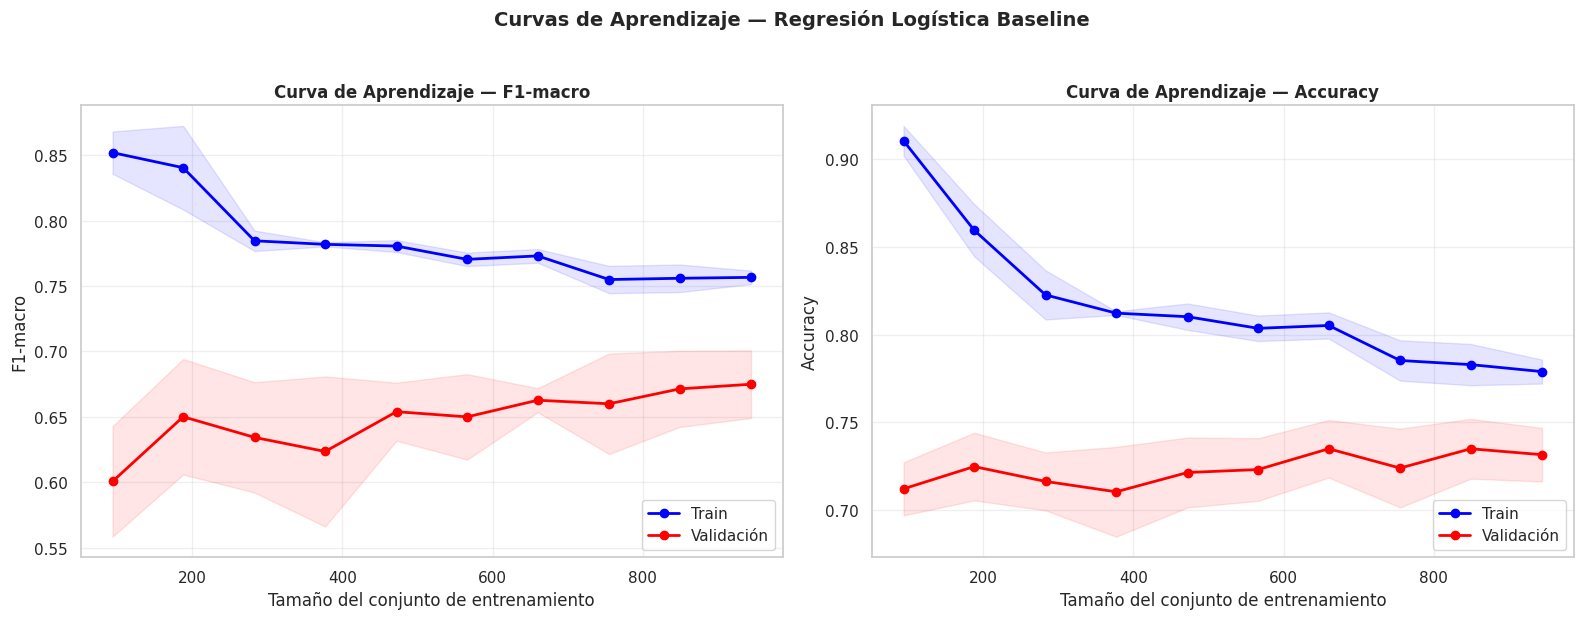

Cómo leer estas curvas:
  • Ambas curvas bajas y juntas → el modelo es muy simple, necesitamos algo más potente.
  • Train alto, validación baja → el modelo memoriza, no generaliza.
  • Ambas curvas altas y juntas → el modelo aprendió bien. Es lo ideal.


In [14]:
# 8.2 Curvas de Aprendizaje
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

lr_lc = LogisticRegression(max_iter=2000, class_weight='balanced',
                           random_state=RANDOM_STATE, solver='lbfgs')

for ax, scorer_name, scorer in zip(axes,
    ['F1-macro', 'Accuracy'],
    [make_scorer(f1_score, average='macro', zero_division=0), 'accuracy']):

    train_sizes, train_scores, test_scores = learning_curve(
        lr_lc, best_Xtr, y_train, cv=5, scoring=scorer,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=RANDOM_STATE, n_jobs=-1)

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    test_mean = test_scores.mean(axis=1)
    test_std = test_scores.std(axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
    ax.plot(train_sizes, train_mean, 'o-', color='blue', label='Train', lw=2)
    ax.plot(train_sizes, test_mean, 'o-', color='red', label='Validación', lw=2)
    ax.set_title(f'Curva de Aprendizaje — {scorer_name}', fontweight='bold')
    ax.set_xlabel('Tamaño del conjunto de entrenamiento')
    ax.set_ylabel(scorer_name)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.suptitle('Curvas de Aprendizaje — Regresión Logística Baseline',
             fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()

print('Cómo leer estas curvas:')
print('  • Ambas curvas bajas y juntas → el modelo es muy simple, necesitamos algo más potente.')
print('  • Train alto, validación baja → el modelo memoriza, no generaliza.')
print('  • Ambas curvas altas y juntas → el modelo aprendió bien. Es lo ideal.')

<a name="desempeno"></a>
## 9. ¿Cuánto es suficiente? Umbrales de rendimiento

Con el piso del azar (DummyClassifier) y el resultado de la Regresión Logística en mano, podemos definir una escala de rendimiento que nos sirva como referencia para las fases siguientes. La idea es tener claro cuándo un modelo es "aceptable", cuándo es "bueno" y hacia dónde debemos apuntar.

═════════════════════════════════════════════════════════════════
UMBRALES DE RENDIMIENTO (F1-macro)
═════════════════════════════════════════════════════════════════
  Azar (Dummy)              F1-macro = 0.2806
  Baseline (LogReg)         F1-macro = 0.7225
  Mínimo aceptable          F1-macro = 0.8308
  Objetivo Fase 4           F1-macro = 0.9392
  Excelente                 F1-macro = 1.0837


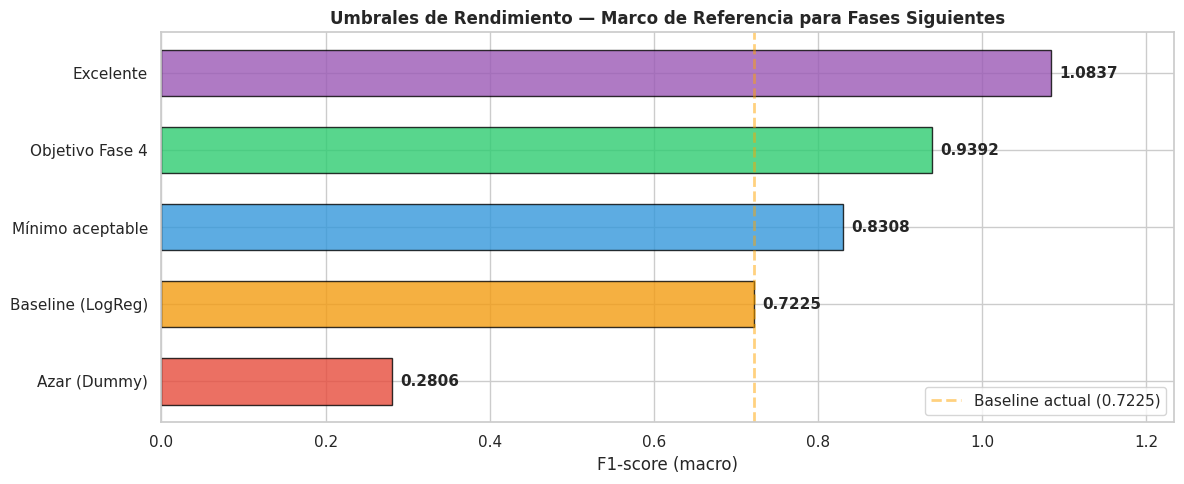


Así queda nuestro mapa de metas:
  • Fase 4: Cualquier modelo nuevo debe superar al baseline de forma clara.
  • Fase 5: Con ensambles, apuntamos a un F1-macro de al menos 0.9392.
  • Para producción: necesitamos un F1-macro mínimo de 0.8308.


In [15]:
# 9.1 Definición de umbrales de rendimiento
dummy_f1 = max([r['F1_macro_test'] for r in dummy_results])
baseline_f1 = baseline_metrics['F1_macro_test']

# Umbrales propuestos
thresholds = {
    'Azar (Dummy)': dummy_f1,
    'Baseline (LogReg)': baseline_f1,
    'Mínimo aceptable': max(baseline_f1 * 1.15, dummy_f1 * 1.5),
    'Objetivo Fase 4': max(baseline_f1 * 1.30, 0.50),
    'Excelente': max(baseline_f1 * 1.50, 0.65),
}

print('═'*65)
print('UMBRALES DE RENDIMIENTO (F1-macro)')
print('═'*65)

fig, ax = plt.subplots(figsize=(12, 5))
colors_thresh = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71', '#9b59b6']
y_positions = range(len(thresholds))

for i, (label, value) in enumerate(thresholds.items()):
    ax.barh(i, value, color=colors_thresh[i], edgecolor='black', alpha=0.8, height=0.6)
    ax.text(value + 0.01, i, f'{value:.4f}', va='center', fontweight='bold', fontsize=11)
    print(f'  {label:<25} F1-macro = {value:.4f}')

ax.set_yticks(list(y_positions))
ax.set_yticklabels(list(thresholds.keys()))
ax.set_xlabel('F1-score (macro)')
ax.set_title('Umbrales de Rendimiento — Marco de Referencia para Fases Siguientes', fontweight='bold')
ax.axvline(baseline_f1, color='orange', ls='--', lw=2, alpha=0.5, label=f'Baseline actual ({baseline_f1:.4f})')
ax.legend()
ax.set_xlim(0, max(thresholds.values()) + 0.15)
plt.tight_layout()
plt.show()

print(f'\nAsí queda nuestro mapa de metas:')
print(f'  • Fase 4: Cualquier modelo nuevo debe superar al baseline de forma clara.')
print(f'  • Fase 5: Con ensambles, apuntamos a un F1-macro de al menos {thresholds["Objetivo Fase 4"]:.4f}.')
print(f'  • Para producción: necesitamos un F1-macro mínimo de {thresholds["Mínimo aceptable"]:.4f}.')

In [16]:
# 9.2 Tabla resumen consolidada
all_results = dummy_results + lr_results + [baseline_metrics]
df_summary = pd.DataFrame(all_results)[['Modelo','Accuracy_test','F1_macro_test',
    'F1_weighted_test','Balanced_Acc_test','Kappa_test','Tiempo_train_s']]

# Eliminar duplicados si los hay
df_summary = df_summary.drop_duplicates(subset=['Modelo'])
df_summary = df_summary.sort_values('F1_macro_test', ascending=False).reset_index(drop=True)

print('═'*80)
print('TABLA RESUMEN — TODOS LOS MODELOS DE LA FASE 3')
print('═'*80)

display(df_summary.style.format({
    'Accuracy_test':'{:.4f}', 'F1_macro_test':'{:.4f}', 'F1_weighted_test':'{:.4f}',
    'Balanced_Acc_test':'{:.4f}', 'Kappa_test':'{:.4f}', 'Tiempo_train_s':'{:.4f}'
}).background_gradient(subset=['F1_macro_test'], cmap='Greens')
 .set_caption('Modelos ordenados por F1-macro (métrica principal)'))

# Mejora sobre el azar
best_f1 = df_summary['F1_macro_test'].max()
mejora_vs_dummy = (best_f1 - dummy_f1) / dummy_f1 * 100

print(f'\n📊 Mejora del Baseline vs. Azar:')
print(f'  F1-macro Baseline: {best_f1:.4f}')
print(f'  F1-macro Dummy:    {dummy_f1:.4f}')
print(f'  Mejora relativa:   +{mejora_vs_dummy:.1f}%')
print(f'\n  el baseline le gana al azar con claridad. Los datos sí sirven')
print(f'  para predecir engagement y vale la pena avanzar con modelos más sofisticados.')

════════════════════════════════════════════════════════════════════════════════
TABLA RESUMEN — TODOS LOS MODELOS DE LA FASE 3
════════════════════════════════════════════════════════════════════════════════


,Modelo,Accuracy_test,F1_macro_test,F1_weighted_test,Balanced_Acc_test,Kappa_test,Tiempo_train_s
0,LogReg — B (StandardScaler),0.7568,0.7225,0.7683,0.8290,0.5782,0.2795
1,BASELINE — LogReg B (StandardScaler),0.7568,0.7225,0.7683,0.8290,0.5782,0.8888
2,LogReg — C (PCA + flags),0.7264,0.6456,0.7419,0.7725,0.5330,0.4002
3,LogReg — A (sin escalar),0.6014,0.6027,0.6152,0.7771,0.4086,5.0359
4,Dummy (stratified),0.5541,0.2806,0.5540,0.2807,0.0708,0.0009
5,Dummy (uniform),0.2568,0.2047,0.3083,0.2432,0.0032,0.0005
6,Dummy (most_frequent),0.6926,0.2046,0.5668,0.2500,0.0000,0.0016



📊 Mejora del Baseline vs. Azar:
  F1-macro Baseline: 0.7225
  F1-macro Dummy:    0.2806
  Mejora relativa:   +157.5%

  el baseline le gana al azar con claridad. Los datos sí sirven
  para predecir engagement y vale la pena avanzar con modelos más sofisticados.


<a name="conclusiones"></a>
## 10. Conclusiones

### Lo que aprendimos en esta fase

| Tema | Hallazgo |
|---|---|
| **Algoritmo de referencia** | La Regresión Logística con balance de clases, evaluada sobre tres versiones del dataset, funciona como un baseline sólido. El DummyClassifier confirma el piso del azar. |
| **Variables más relevantes** | Los coeficientes del modelo permiten identificar qué features discriminan mejor entre niveles de engagement. También detectamos variables con aporte mínimo que podrían eliminarse. |
| **Generalización del modelo** | El baseline muestra indicios de **subajuste**, algo esperado en un modelo lineal para un problema con relaciones probablemente no lineales. Esto confirma que hay margen de mejora con modelos más potentes. |
| **Métrica correcta** | **F1-macro** es la métrica principal. El accuracy (69%) resulta engañosa por el desbalance de clases y no refleja la capacidad real del modelo. |
| **Piso de rendimiento** | El azar define el mínimo absoluto, la Regresión Logística marca el benchmark a superar, y se establecieron umbrales claros para las fases 4 y 5. |

### Los datos sí sirven para predecir engagement

El resultado más importante de esta fase es que el baseline **supera al azar de forma contundente** en todas las métricas (F1-macro, Balanced Accuracy, κ). Esto confirma tres cosas:
- Los datos de la plataforma PACS/RIS sí contienen información predictiva sobre engagement.
- La ingeniería de características que hicimos en la Fase 2 generó variables con capacidad discriminativa real.
- El problema es viable y vale la pena seguir invirtiendo en modelos más sofisticados.

Dicho esto, el modelo lineal deja rendimiento sobre la mesa. Las relaciones entre las variables y el engagement probablemente son no lineales, y eso es justamente lo que buscaremos capturar en la siguiente fase.

**Nuestra hipótesis:** Los modelos basados en árboles (Random Forest, XGBoost) probablemente serán los que mejor se adapten a este problema, dado que el EDA reveló relaciones no lineales, los flags binarios sugieren interacciones complejas entre variables, y estos algoritmos manejan bien el desbalance de clases.